In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#connnecting drive with google colab
from google.colab import drive
import pickle
drive.mount('/content/drive/')
#read the csv file
macro_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Final_csv/RELIANCE.csv', parse_dates= ['Datetime'], index_col='Datetime')
#macro_data=pd.DataFrame(df)
#macro_data['date']=macro_data['date'].apply(pd.to_datetime)
#macro_data.set_index('date',inplace=True)


Mounted at /content/drive/


In [ ]:
print(macro_data.shape)  
macro_data.head()

(2075, 6)


,Open,High,Low,Close,Volume,6
Datetime,,,,,,
2021-12-17 09:15:00+05:30,2398.05,2407.70,2377.95,2378.70,557367,0
2021-12-17 09:30:00+05:30,2378.70,2382.30,2371.20,2373.20,296441,0
2021-12-17 09:45:00+05:30,2373.05,2374.95,2358.10,2360.30,386764,0
2021-12-17 10:00:00+05:30,2360.30,2364.05,2351.25,2363.75,494521,0
2021-12-17 10:15:00+05:30,2363.80,2363.80,2353.05,2359.70,201781,0


In [ ]:
macro_data=macro_data.drop(["Volume"],axis= 1)

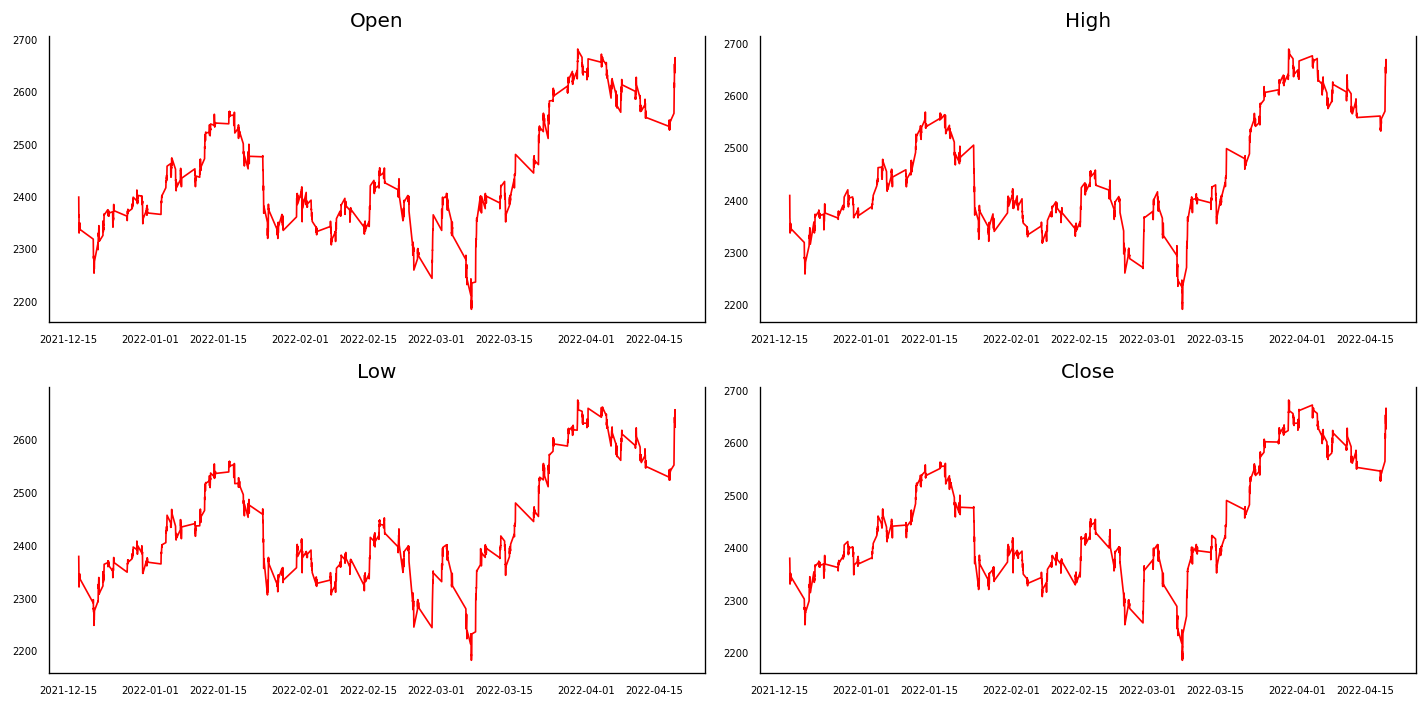

In [ ]:
fig, axes = plt.subplots( nrows=2, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
macro_data = macro_data.dropna()

In [ ]:
macro_data.head()

,Open,High,Low,Close,6
Datetime,,,,,
2021-12-17 09:15:00+05:30,2398.05,2407.70,2377.95,2378.70,0
2021-12-17 09:30:00+05:30,2378.70,2382.30,2371.20,2373.20,0
2021-12-17 09:45:00+05:30,2373.05,2374.95,2358.10,2360.30,0
2021-12-17 10:00:00+05:30,2360.30,2364.05,2351.25,2363.75,0
2021-12-17 10:15:00+05:30,2363.80,2363.80,2353.05,2359.70,0


Checking if data is stationary or not. If p value is less than 0.05 than data is stationary otherwise data is not stationary. By doing 1st order differencing we are making the data stationary.

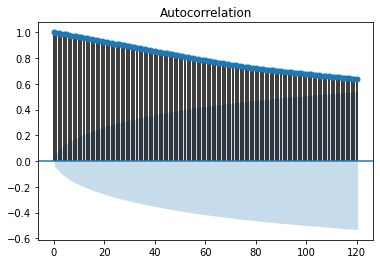

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(macro_data['Open'], lags=120)
plt.show()

In [ ]:

for i in range(len(macro_data.columns)):
  result = adfuller(macro_data[macro_data.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(macro_data.columns[i]))
  else:
    print('{} - Series is Stationary'.format(macro_data.columns[i]))

Open - Series is not Stationary
High - Series is not Stationary
Low - Series is not Stationary
Close - Series is not Stationary
6 - Series is Stationary


Granger Causality test is used to check correlation between the two time series. Tells whether the time series in the second column causes the time series in the first column. Currently doing for 8 lags but we can do for multiple lags. If p=0 means the second column causes the time series in the first column.

In [ ]:
dataset=macro_data

In [ ]:
max_lags=8
y='Close'
for i in range(len(dataset.columns)-1):
  results=grangercausalitytests(dataset[[y,dataset.columns[i+1]]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(dataset.columns[i+1],p_values))

Column - High : P_Values - [0.4783, 0.0616, 0.2134, 0.3049, 0.3043, 0.2986, 0.2851, 0.2083]
Column - Low : P_Values - [0.4983, 0.3169, 0.8752, 0.8136, 0.8396, 0.9187, 0.9466, 0.9438]
Column - Close : P_Values - [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Column - 6 : P_Values - [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
dataset=macro_data.drop(["6"],axis= 1)

In [ ]:
df_train = dataset[:int(0.95*(len(dataset)))]
df_test = dataset[int(0.95*(len(dataset))):]

In [ ]:
df_train.shape

(1971, 4)

In [ ]:
df_test.shape


(104, 4)

Select order help us to select the maximum lags. For a good model all the parameters should be minimum as possible. Normally only looking at AIC score is also sufficient. Star highlight where minimum is found. We need to consider that lag where minimum was found was further processing.

In [ ]:
model = VAR(df_train)
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,17.35,17.36,3.417e+07,17.35
1,10.74,10.79*,4.604e+04,10.76*
2,10.72,10.83,4.537e+04,10.76
3,10.72,10.87,4.520e+04,10.77
4,10.72*,10.91,4.518e+04*,10.79
5,10.73,10.97,4.557e+04,10.82
6,10.73,11.02,4.590e+04,10.84
7,10.74,11.07,4.613e+04,10.86
8,10.75,11.13,4.655e+04,10.89
9,10.76,11.18,4.689e+04,10.91


In [ ]:
results = model.fit(4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Apr, 2022
Time:                     11:59:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    10.9123
Nobs:                     1967.00    HQIC:                   10.7901
Log likelihood:          -21638.5    FPE:                    45215.9
AIC:                      10.7192    Det(Omega_mle):         43686.0
--------------------------------------------------------------------
Results for equation Open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.227424         2.294635            0.971           0.332
L1.Open          0.003724         0.035310            0.105           0.916
L1.High          0.011907         0.035909            0.332           0.740
L1.Lo

VARMAX Class make forecasting easier. We are providing the non stationary data and not difference data. Order(Autoregression,Moving Average part).Enforce stationarity will make are data stationary.

In [ ]:
lag=results.k_ar

In [ ]:
results.forecast(df_train.values[-lag:],steps=5)

array([[2625.51733432, 2628.99776031, 2620.34696384, 2624.07127808],
       [2623.65363138, 2627.91359358, 2619.31119399, 2623.8179174 ],
       [2623.6099819 , 2627.79090319, 2619.44173796, 2623.66238137],
       [2623.67812643, 2627.85780078, 2619.56973652, 2623.67927909],
       [2623.42668558, 2627.67753702, 2619.13887928, 2623.43876558]])

In [ ]:
fc = results.forecast(df_test.values[-lag:], steps=len(df_test))
df_forecast = pd.DataFrame(fc, index=macro_data.index[-len(df_test):], columns=df_train.columns + '_forecast')
df_forecast

,Open_forecast,High_forecast,Low_forecast,Close_forecast
Datetime,,,,
2022-04-11 14:30:00+05:30,2625.216600,2633.134979,2618.079685,2625.895421
2022-04-11 14:45:00+05:30,2626.345202,2631.929065,2618.841041,2623.887200
2022-04-11 15:00:00+05:30,2623.250025,2630.045774,2616.532995,2623.773833
2022-04-11 15:15:00+05:30,2622.546817,2628.403442,2616.259171,2622.555852
2022-04-12 09:15:00+05:30,2622.162567,2627.425206,2616.657523,2621.974728
...,...,...,...,...
2022-04-19 14:15:00+05:30,2599.223097,2603.534680,2594.839320,2599.213083
2022-04-19 14:30:00+05:30,2599.016139,2603.328120,2594.631984,2599.006394
2022-04-19 14:45:00+05:30,2598.809602,2603.121981,2594.425071,2598.800127


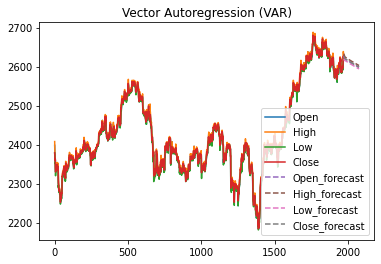

In [ ]:
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().endswith('_forecast'):
            data[col].plot(label=col,linestyle="dashed")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()
show_graph(df_train, df_forecast, "Vector Autoregression (VAR)")

In [ ]:
from sklearn.metrics import mean_squared_error
import math 
from statistics import mean

rmse_Open=math.sqrt(mean_squared_error(df_forecast['Open_forecast'],df_test['Open']))
print('Mean value of Open is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Open']),rmse_Open))
rmse_High=math.sqrt(mean_squared_error(df_forecast['High_forecast'],df_test['High']))
print('Mean value of High is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['High']),rmse_High))
rmse_Low=math.sqrt(mean_squared_error(df_forecast['Low_forecast'],df_test['Low']))
print('Mean value of Low is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Low']),rmse_Low))
rmse_Close=math.sqrt(mean_squared_error(df_forecast['Close_forecast'],df_test['Close']))
print('Mean value of Close is : {}. Root Mean Squared Error is :{}'.format(mean(df_test['Close']),rmse_Close))


Mean value of Open is : 2576.3447115384615. Root Mean Squared Error is :52.412395515656726
Mean value of High is : 2581.5283653846154. Root Mean Squared Error is :52.48488544582612
Mean value of Low is : 2571.39375. Root Mean Squared Error is :52.001470618756954
Mean value of Close is : 2576.4552884615387. Root Mean Squared Error is :52.61262985910469
